### Schema

0. x coordinate
1. y coordinate
2. timestamp
3. pen-up
4. azimuth angle
5. altitude angle
6. Pressure

In [1]:
import pandas as pd
import numpy as np
from os import path
import sys


#plotting
from matplotlib import pyplot as plt

#processing
from scipy.signal import resample


In [2]:
#ml
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import mlflow
import mlflow.tensorflow
tf.__version__

'2.5.0'

In [3]:
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope 

In [4]:
features=['x','y','pen_up','pressure']

Asegurar que la muestra y labels son las correctas

In [5]:
doc_path = "/data/elekin/doc"
metadf=pd.read_csv(path.join(doc_path,"metadata-202106-v1.csv"),index_col=0)
metadf[metadf["temblor"]=='si']

,abs_path,relative_path,temblor,Sexo,TRS,age,level
name,,,,,,,
T001,/data/elekin/data/origin/ethw/protocolo_temblo...,T001/session00001/u00005s00001_hw00001.svc,si,M,36,74,2
T002,/data/elekin/data/origin/ethw/protocolo_temblo...,T002/session00001/u00006s00001_hw00002.svc,si,M,40,71,2
T002,/data/elekin/data/origin/ethw/protocolo_temblo...,T002/session00001/u00006s00001_hw00001.svc,si,M,40,71,2
T005,/data/elekin/data/origin/ethw/protocolo_temblo...,T005/session00001/u00009s00001_hw00001.svc,si,M,29,69,2
T006,/data/elekin/data/origin/ethw/protocolo_temblo...,T006/session00001/u00010s00001_hw00001.svc,si,F,19,77,2
T008,/data/elekin/data/origin/ethw/protocolo_temblo...,T008/session00001/u00013s00001_hw00001.svc,si,F,3,68,1
T009,/data/elekin/data/origin/ethw/protocolo_temblo...,T009/session00001/u00014s00001_hw00001.svc,si,F,16,66,2
T010,/data/elekin/data/origin/ethw/protocolo_temblo...,T010/session00001/u00015s00001_hw00002.svc,si,M,16,61,2
T012,/data/elekin/data/origin/ethw/protocolo_temblo...,T012/session00001/u00005s00001_hw00001.svc,si,F,11,51,1


In [6]:
# Creating a data structure with subjects time series and tremor levels
 
X = []
y = []

# shape input to be 3D [samples, timesteps, features]
for path, level in zip(metadf.abs_path, metadf.level):
    df = pd.read_csv(path, sep="\s+",header=None,names=features,skiprows=1,usecols=[0,1,3,6])
    X.append(resample(df.values.astype('int16'), 4096))
    y.append(level)
dim = np.array(X).shape
print("{} samples,{} timesteps, {} features".format(dim[0], dim[1], dim[2]))

53 samples,4096 timesteps, 4 features


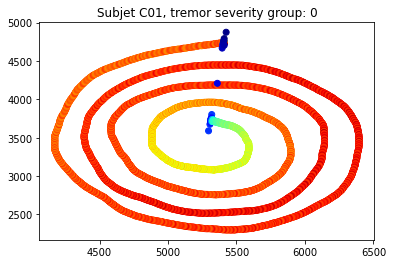

In [7]:
idx = 0
label = y[idx]
plt.scatter(X[idx][:,0], X[idx][:,1], c=X[idx][:,3], cmap='jet')
_=plt.title("Subjet {}, tremor severity group: {}".format(metadf.index[idx], label))

In [8]:
seed = 38
n_outputs = 3
mini_batch_size=4

n_timesteps = np.array(X).shape[1]
n_features = np.array(X).shape[2]

data_size = np.array(X).shape[0]
train_split = 0.67
test_split = 0.33
train_size = int(train_split * data_size)
test_size = int(test_split * data_size)

shuffle_buffer = data_size
steps_per_epoch = round(data_size/mini_batch_size)


AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time

MLFLOW_TRACKING_URI = "http://mlflow_server:5000"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment('/archimedes-dl')

In [9]:
# label encoding
labels = tf.one_hot(y,n_outputs)

In [10]:
# train, val split
dataset = tf.data.Dataset.from_tensor_slices((X, labels))
full_dataset = dataset.shuffle(shuffle_buffer, seed=seed)
train_dataset = full_dataset.take(train_size).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = full_dataset.skip(train_size).batch(mini_batch_size).prefetch(AUTOTUNE).cache()

In [11]:
# for feat, targ in train_dataset.shuffle(shuffle_buffer):
# #         print ('Features: {0}'.format(feat, targ))
#     print ('Target train: {1}'.format(feat, targ))
    
# for feat, targ in test_dataset.shuffle(shuffle_buffer):
# #         print ('Features test: {}, Target test: {}'.format(feat, targ))
#         print ('Target test: {1}'.format(feat, targ))

# print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
#                                                                               len(test_dataset),
#                                                                               mini_batch_size,
#                                                                                 steps_per_epoch))

In [21]:
## search space

space = {'rate'       : hp.uniform('rate',0.01,0.5),
         'units'      : hp.quniform('units',32,64,128),
         'layers'     : hp.quniform('layers',1,6,1),
        }

{'rate': <hyperopt.pyll.base.Apply at 0x7fc7501be5f8>,
 'units': <hyperopt.pyll.base.Apply at 0x7fc7501be668>,
 'layers': <hyperopt.pyll.base.Apply at 0x7fc7501bec50>}

In [20]:
def f_nn(hparams):
    
    model = tf.keras.models.Sequential()
    if hparams['layers'] == 1:
        model.add(tf.keras.layers.LSTM(hparams['units'], activation=tf.nn.tanh, return_sequences=False, input_shape=(n_timesteps,n_features)))
        model.add(tf.keras.layers.Dropout(hparams['rate']))
    else:
        model.add(tf.keras.layers.LSTM(hparams['units'], activation=tf.nn.tanh, return_sequences=True, input_shape=(n_timesteps,n_features)))
        model.add(tf.keras.layers.Dropout(hparams['rate']))
        
        for i in range(hparams['layers']-2):
            model.add(tf.keras.layers.LSTM(hparams['units'], activation=tf.nn.tanh, return_sequences=True ))
            model.add(tf.keras.layers.Dropout(hparams['rate']))
    
        model.add(tf.keras.layers.LSTM(hparams['units'], activation=tf.nn.tanh, return_sequences=False ))
        model.add(tf.keras.layers.Dropout(hparams['rate']))
    
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.sigmoid))
              
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
              
    result = model.fit(train_dataset, 
                       use_multiprocessing=True, 
                       validation_data=test_dataset, 
                       batch_size=4, epochs=200)
    
    validation_acc = np.amax(result.history['val_accuracy'])
    print('Best validation loss of epoch:', validation_acc)
    return {'accuracy': validation_acc, 
            'status': STATUS_OK, 
            'model': model, 
            'params': hparams}

In [18]:
run = 'lstm/hp'
trials = Trials()
best = fmin(f_nn, 
            space, 
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

{'layers': 4, 'rate': 0.1729328693094867, 'units': 0} 
Epoch 1/200                                           
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception:    CUDNN_STATUS_BAD_PARAM
in tensorflow/stream_executor/cuda/cuda_dnn.cc(1173): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_31684]

Function call stack:
train_function -> train_function -> train_function



  0%|          | 0/50 [00:03<?, ?trial/s, best loss=?]


UnknownError:    CUDNN_STATUS_BAD_PARAM
in tensorflow/stream_executor/cuda/cuda_dnn.cc(1173): 'cudnnSetRNNDescriptor_v8( rnn_desc.get(), rnn_algo, rnn_mode, bias_mode, direction_mode, input_mode, data_type, compute_type, math_type, input_size, hidden_size, proj_size, num_layers, dropout_desc.handle(), aux_flags)'
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_31684]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
mlflow.end_run()